# Snowmelt Runoff Onset Date Validation with Nooksack River (Streamgage at Glacier Creek)

In [1]:
!pip install -q 'setuptools<58'
!pip install -q ulmo
!pip install -q hydrofunctions

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import matplotlib
import sys
import os
import dask_gateway
import planetary_computer
from rechunker import rechunk
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils
import contextily as ctx
import rioxarray as rxr
import pathlib
import glob
import re
import hydrofunctions as hf
import ulmo
%matplotlib inline

In [3]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=20, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.0677cbc93e6d43068ec528ac00a607da/status


In [17]:
gj = '../input/shapefiles/mt_baker.geojson'     

baker_watersheds = gpd.read_file('../input/shapefiles/baker_watersheds.geojson')
glacier_creek = baker_watersheds[baker_watersheds.Name=='Glacier Creek']
glacier_creek_latlon = baker_watersheds[baker_watersheds.Name=='Glacier Creek'].to_crs('EPSG:4326')

#baker_watersheds = gpd.read_file('../input/shapefiles/whitewater_river_wbd.geojson')
#glacier_creek = baker_watersheds.to_crs('EPSG:32610')
#glacier_creek_latlon = baker_watersheds.to_crs('EPSG:4326')

Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


## Let's bring in the streamgage data using hydrofunctions

In [5]:
site_no = '12205245' # glacier creek gage https://waterdata.usgs.gov/wa/nwis/inventory/?site_no=12205245&agency_cd=USGS
#site_no = '14091500' # mt jefferson

In [6]:
request = hf.NWIS(site_no,start_date='2014-01-01',end_date='2023-01-01')
glacier_creek_gage = request.df()

site_lat = request.meta[f'USGS:{site_no}']['siteLatLongSrs']['latitude']
site_lon = request.meta[f'USGS:{site_no}']['siteLatLongSrs']['longitude']
site_crs = request.meta[f'USGS:{site_no}']['siteLatLongSrs']['srs']
coords = pd.DataFrame({'longitude': [site_lon], 'latitude': [site_lat]})
site_location = gpd.points_from_xy(coords.longitude,coords.latitude,crs=site_crs)
site = gpd.GeoDataFrame(['Streamgage'],geometry=site_location)

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12205245&startDT=2014-01-01&endDT=2023-01-01


(48.5793194, 49.1793194)

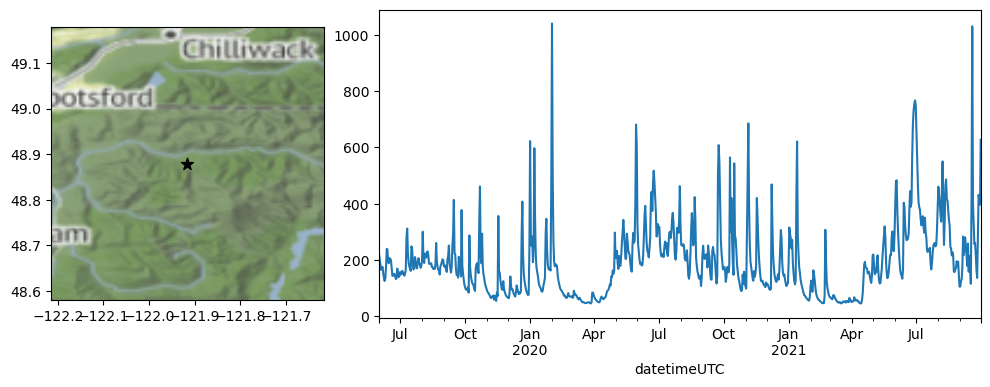

In [7]:
f,ax=plt.subplot_mosaic("ABB",figsize=(12,4))
site.plot(ax=ax['A'],color='black',marker='*',markersize=80)
glacier_creek_gage.iloc[:,0].plot(ax=ax['B'])
ctx.add_basemap(ax=ax['A'], crs=site_crs, source=ctx.providers.Stamen.Terrain, attribution=False)
ax['A'].set_xlim([coords['longitude'][0]-0.3,coords['longitude'][0]+0.3])
ax['A'].set_ylim([coords['latitude'][0]-0.3,coords['latitude'][0]+0.3])

In [8]:
# Let's look at 2020
year = 2020
years = [2015,2016,2017,2018,2019,2020,2021,2022]
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [22]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(glacier_creek_latlon,start_time=f'2023-09-01',end_time=f'2024-12-31',polarization='all',resolution=10)

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [24]:
ts_ds.time

<xarray.DataArray 'time' (time: 13)>
array(['2023-09-01T14:21:43.992708000', '2023-09-05T01:54:52.576308000',
       '2023-09-08T14:13:26.428483000', '2023-09-08T14:13:53.451363000',
       '2023-09-10T02:02:56.040646000', '2023-09-10T02:03:21.040880000',
       '2023-09-13T14:21:44.321274000', '2023-09-17T01:54:47.346319000',
       '2023-09-17T01:55:13.144881000', '2023-09-20T14:13:26.683796000',
       '2023-09-20T14:13:53.705975000', '2023-09-22T02:02:56.267902000',
       '2023-09-22T02:03:21.268277000'], dtype='datetime64[ns]')
Coordinates: (12/34)
  * time                                   (time) datetime64[ns] 2023-09-01T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2023...
    s1:resolution                          <U4 'high'
    sar:looks_azimuth                      int64 1
    s1:datatake_id                         (time) <U6 '395424' ... '398014'
    sar:looks_equivalent_number            float64 4.4
    ...                                     ...
    platform                               <U11 'SENTINEL-1A'
    sar:center_frequency                   float64 5.405
    end_datetime                           (time) <U32 '2023-09-01 14:21:56.4...
    sar:pixel_spacing_range                int64 10
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 32610

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.11/ssl.py", line 1346, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1002)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 192, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._h

In [ ]:
for year in years:
    #bbox_gdf = gpd.read_file(gj)
    ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(glacier_creek_latlon,start_time=f'{year}-01-01',end_time=f'{year}-12-31',polarization='all',resolution=10)
    #worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)
    #ts_ds = ts_ds.where(worldcover.isin(classes))
    ts_ds = ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False)

    melt_year = slice(f'{year}-02-01',f'{year}-09-30')
    ts_ds_oneyear = ts_ds.sel(time=melt_year)

    runoffs_median = s1_rtc_bs_utils.get_runoff_onset(ts_ds_oneyear,num_acquisitions_during_melt_season=6)
    runoffs_median_doy = runoffs_median.dt.dayofyear
    runoff_onset_map = runoffs_median_doy.where(runoffs_median_doy>0).compute()

    f,ax=plt.subplots(1,2,figsize=(30,10),gridspec_kw={'width_ratios': [1, 2]})

    start_date = f'{year}-01-01'
    end_date = f'{year+1}-01-01'

    runoff_onset_map.plot(ax=ax[0],vmin=80,vmax=230)
    ax[0].axis('equal')
    site.to_crs(ts_ds.rio.crs).plot(ax=ax[0],color='black',marker='*',markersize=80,label='Glacier Creek Streamgage')
    glacier_creek_latlon.to_crs(ts_ds.rio.crs).geometry.boundary.plot(ax=ax[0],color='black',linewidth=5,label='Glacier Creek Watershed')
    ax[0].legend()

    ctx.add_basemap(ax=ax[0], crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)
    ax[0].set_title('Snowmelt Runoff Onset [DOY]')

    ax_streamgage=ax[1].twinx()
    #s1_rtc_bs_utils.get_runoff_onset(ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False)).plot.hist(ax=ax[1],color='blue',bins=20) # crop to watershed outline
    runoffs_median.plot.hist(ax=ax[1],color='blue',bins=20)
    glacier_creek_gage.iloc[:,0].plot(ax=ax_streamgage,color='orange',linewidth=8)
    ax[1].set_ylabel('Number of Pixels')
    ax_streamgage.set_ylabel('Dischange [cfs]')
    ax[1].set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
    ax[1].set_title('Snowmelt Runoff Onset Area and Streamgage Dischange')

    plt.tight_layout()

## Let's include a SNOTEL site for meterology info

In [ ]:
f,ax=plt.subplots(figsize=(15,15))
s1_rtc_bs_utils.plot_closest_snotel(ts_ds.sel(band='vv'),ax=ax,distance_cutoff=5)

In [ ]:
year = 2020
start_date = f'{year}-01-01'
end_date = f'{year+1}-01-01'
    
    
#bbox_gdf = gpd.read_file(gj)
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(glacier_creek_latlon,start_time=f'{year}-01-01',end_time=f'{year}-12-31',polarization='all',resolution=10)
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)
ts_ds = ts_ds.where(worldcover.isin(classes))
ts_ds = ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False)

melt_year = slice(f'{year}-02-01',f'{year}-09-30')
ts_ds_oneyear = ts_ds.sel(time=melt_year)

runoffs_median = s1_rtc_bs_utils.get_runoff_onset(ts_ds_oneyear,num_acquisitions_during_melt_season=6)
runoffs_median_doy = runoffs_median.dt.dayofyear
runoff_onset_map = runoffs_median_doy.where(runoffs_median_doy>0).compute()

In [ ]:
#f,ax=plt.subplots(1,2,figsize=(30,10),gridspec_kw={'width_ratios': [1, 2]})
f,ax=plt.subplot_mosaic("ABB;ACC",figsize=(30,10))

runoff_onset_map.plot(ax=ax['A'],vmin=80,vmax=230)
ax['A'].axis('equal')
site.to_crs(ts_ds.rio.crs).plot(ax=ax['A'],color='black',marker='*',markersize=200,label='Glacier Creek Streamgage')


sites_gdf = s1_rtc_bs_utils.find_closest_snotel(ts_ds.sel(band='vv').rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False))
sites_gdf[sites_gdf['distance_km']==sites_gdf['distance_km'].min()].plot(ax=ax['A'],color='red',marker='*',markersize=200,label=f'{sites_gdf.name[0]} SNOTEL',zorder=2)

glacier_creek.geometry.boundary.plot(ax=ax['A'],color='black',linewidth=5,label='Glacier Creek Watershed',zorder=1)


ax['A'].legend(facecolor='white', frameon=True,framealpha=1,fontsize='small')


ax['A'].legend()

ctx.add_basemap(ax=ax['A'], crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)
ax['A'].set_title('Snowmelt Runoff Onset [DOY]')



ax_streamgage=ax['B'].twinx()
s1_rtc_bs_utils.get_runoff_onset(ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False)).plot.hist(ax=ax['B'],color='blue',bins=20) # crop to watershed outline
glacier_creek_gage.iloc[:,0].plot(ax=ax_streamgage,color='orange',linewidth=8)
ax['B'].set_ylabel('Number of Pixels')
ax_streamgage.set_ylabel('Dischange [cfs]')
ax['B'].set_title('Snowmelt Runoff Onset Area and Streamgage Dischange')
ax['B'].set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   


snotel_precip = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False),variable_code='SNOTEL:PRCPSA_D',distance_cutoff=30,closest=True, start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
snotel_temp = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False),variable_code='SNOTEL:TAVG_D',distance_cutoff=30,closest=True, start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
snotel_temp=(snotel_temp-32)/1.8
temp_precip_gdf = pd.concat([snotel_temp,snotel_precip],axis=1,join='inner')
temp_precip_gdf = temp_precip_gdf.set_axis(['Temperature','Precip'],axis=1)#,inplace=True)
conditions = [(temp_precip_gdf['Temperature'] <=0),(temp_precip_gdf['Temperature'] > 0)]
values = ['lightcoral', 'blue']
temp_precip_gdf['bar_color'] = np.select(conditions, values)
    
    
precip_plot = ax['C'].bar(temp_precip_gdf.index,2.54*temp_precip_gdf.iloc[:,1],color=temp_precip_gdf['bar_color'],alpha=1,label='Precipitation')
ax['C'].set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
ax['C'].set_ylim([0,18])
ax['C'].set_title(f'{sites_gdf.name[0]} SNOTEL Site Precipitation and Temperature')
ax['C'].set_ylabel('Precipitation [cm]')
#ax['C'].legend()
colors = {'Snow':'lightcoral', 'Rain':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax['C'].legend(handles, labels, loc='upper left')

ax_temp = ax['C'].twinx()
snotel_temp.plot(ax=ax_temp,label='Temperature',color='black',linewidth=0,marker='.')
ax_temp.set_ylabel('Temperature [C]')
ax_temp.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
ax_temp.set_ylim([-10,22])
ax_temp.legend(['Temperature'],loc='upper right')

ax_temp.hlines(y=0,xmin=datetime.strptime(start_date,'%Y-%m-%d'),xmax=datetime.strptime(end_date,'%Y-%m-%d'),color='black',linestyle='--')

plt.tight_layout()

## And stuff it all on one plot

In [ ]:
#f,ax=plt.subplots(1,2,figsize=(30,10),gridspec_kw={'width_ratios': [1, 2]})
f,ax=plt.subplot_mosaic("ABB;ABB",figsize=(16,6))

txtsize=14

runoff_onset_map.plot(ax=ax['A'],vmin=80,vmax=230,cbar_kwargs={'label': "Day of year"})
ax['A'].axis('equal')
site.to_crs(ts_ds.rio.crs).plot(ax=ax['A'],color='black',marker='*',markersize=200,label='Glacier Creek streamgage')


sites_gdf = s1_rtc_bs_utils.find_closest_snotel(ts_ds.sel(band='vv').rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False))
sites_gdf[sites_gdf['distance_km']==sites_gdf['distance_km'].min()].plot(ax=ax['A'],color='red',marker='*',markersize=200,label=f'{sites_gdf.name[0]} SNOTEL',zorder=2)

glacier_creek.geometry.boundary.plot(ax=ax['A'],color='black',linewidth=5,label='Glacier Creek watershed',zorder=1)


ax['A'].legend(facecolor='white', frameon=True,framealpha=1,fontsize='small')


ctx.add_basemap(ax=ax['A'], crs=ts_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)
ax['A'].set_title('Snowmelt runoff onset\n',fontsize=txtsize+1)
ax['A'].axis('off')

ax_streamgage=ax['B'].twinx()
ax_streamgage.spines.right.set_position(("axes", 1.08))

s1_rtc_bs_utils.get_runoff_onset(ts_ds.rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False)).plot.hist(ax=ax['B'],color='green',bins=20,alpha=0.4,label='Pixels experiencing \nsnowmelt runoff onset') # crop to watershed outline
ax['B'].legend(loc='upper left')
glacier_creek_gage.iloc[:,0].plot(ax=ax_streamgage,color='orange',linewidth=3, label='Glacier Creek discharge')
ax['B'].set_ylabel('Pixels [count]',fontsize=txtsize)
ax_streamgage.set_ylabel('Dischange [cfs]',fontsize=txtsize)
ax_streamgage.legend(loc='upper right')
#ax['B'].set_title('Snowmelt Runoff Onset Area and Streamgage Dischange')

snotel_precip = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds.sel(band='vv').rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False),variable_code='SNOTEL:PRCPSA_D',distance_cutoff=30,closest=True, start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
snotel_temp = s1_rtc_bs_utils.get_closest_snotel_data(ts_ds.sel(band='vv').rio.clip(glacier_creek.geometry,glacier_creek.crs,drop=True,invert=False),variable_code='SNOTEL:TAVG_D',distance_cutoff=30,closest=True, start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
snotel_temp=(snotel_temp-32)/1.8
temp_precip_gdf = pd.concat([snotel_temp,snotel_precip],axis=1,join='inner')
temp_precip_gdf = temp_precip_gdf.set_axis(['Temperature','Precip'],axis=1)#,inplace=True)
conditions = [(temp_precip_gdf['Temperature'] <=0),(temp_precip_gdf['Temperature'] > 0)]
values = ['lightcoral', 'blue']
temp_precip_gdf['bar_color'] = np.select(conditions, values)
    
    
ax_precip = ax['B'].twinx()
precip_plot = ax_precip.bar(temp_precip_gdf.index,2.54*temp_precip_gdf.iloc[:,1],color=temp_precip_gdf['bar_color'],alpha=1,label='Precipitation')
ax_precip.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
ax_precip.set_ylim([0,18])
#ax_precip.set_title(f'{sites_gdf.name[0]} SNOTEL Site Precipitation and Temperature')
ax_precip.set_ylabel('Precipitation [cm]',fontsize=txtsize)
#ax['C'].legend()
colors = {'Snow':'lightcoral', 'Rain':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax_precip.legend(handles, labels, loc='upper center')


tkw = dict(size=4, width=1.5)

ax['B'].yaxis.label.set_color('green')
ax['B'].tick_params(axis='y', colors='green', **tkw)


ax_streamgage.yaxis.label.set_color('orange')
ax_streamgage.tick_params(axis='y', colors='orange', **tkw)

ax_precip.yaxis.label.set_color('blue')
ax_precip.tick_params(axis='y', colors='blue', **tkw)

ax_precip.set_ylim([0,30])
ax_streamgage.set_ylim([0,1200])
#ax['B'].set_ylim([0,55000])

ax['B'].set_title('Snowmelt runoff onset area, streamgage dischange, and SNOTEL precipitation\n',fontsize=txtsize+1)

f.tight_layout()
f.savefig('figures/S9.png',dpi=300)